# Introduction

In [1]:
from scipy.io import arff
import pandas as pd

data, meta = arff.loadarff("synth_multidim_100_000.arff")
data = pd.DataFrame(data)

In [2]:
labels = data['class'].astype(int)
labels[labels != 0] = 1
del data['class']

In [3]:
data['labels'] = labels

In [4]:
data['labels'] = 0
data.loc[data.index.isin([50, 121, 350, 572, 669]),'labels'] = 1

In [5]:
# some matplotlib styling
from matplotlib import rc
import matplotlib.pyplot as plt

rc('text', usetex=True)
plt.style.use('seaborn-notebook')
rc('font',**{'family':'serif','serif':['Cambria']})
plt.rcParams['image.cmap'] = 'Reds'
plt.rcParams['patch.linewidth'] = '0.5'
plt.rcParams['patch.edgecolor'] = 'black'
plt.rcParams['axes.titlesize'] = '18'
plt.rcParams['axes.labelsize'] = '18'
plt.rcParams['legend.fontsize'] = '15'
plt.rcParams['xtick.labelsize'] = '12'
plt.rcParams['ytick.labelsize'] = '12'

<IPython.core.display.Javascript object>


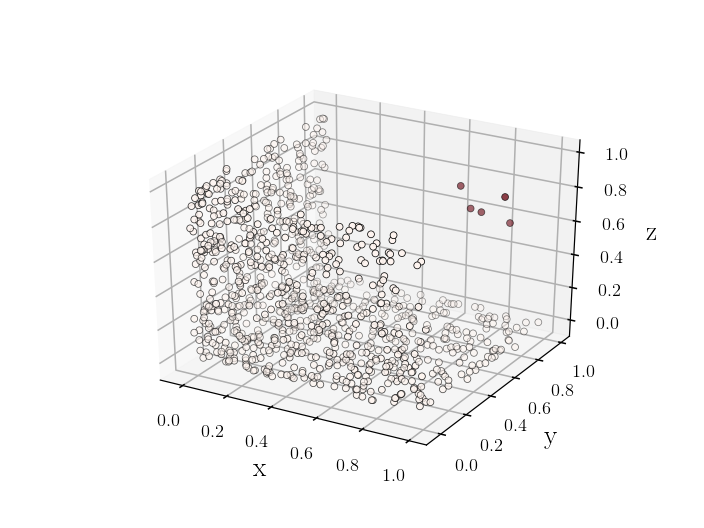

In [6]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D

threedee = plt.figure().gca(projection='3d')
threedee.scatter(data['var_0030'], data['var_0031'], zs=data['var_0032'], 
                 c=data["labels"], edgecolor='black')
threedee.set_xlabel('x', labelpad=10)
threedee.set_ylabel('y', labelpad=10)
threedee.set_zlabel('z', labelpad=10)
plt.savefig("3d-plot-outlier.svg", format="svg")

<IPython.core.display.Javascript object>


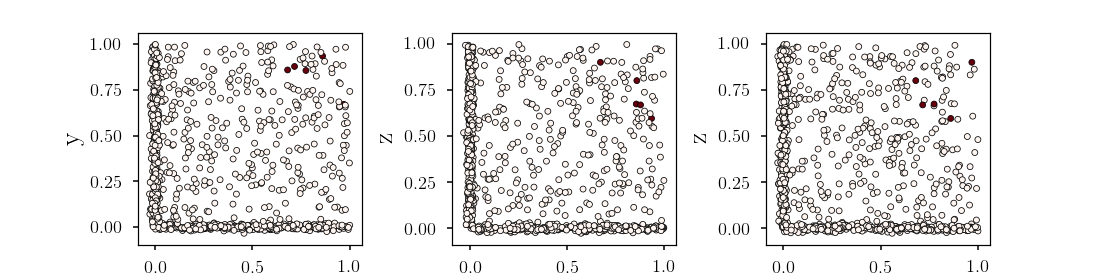

In [7]:
import matplotlib.gridspec as gridspec

# Create 1x3 sub plots
gs = gridspec.GridSpec(1, 3, wspace=0.4)

plt.figure(figsize=(10,2.5))

ax = plt.subplot(gs[0, 0]) # row 0, col 0
plt.scatter(data['var_0030'], data['var_0031'], c=data["labels"], 
            edgecolor='black', s=15)
plt.xlabel('x')
plt.ylabel('y')

ax = plt.subplot(gs[0, 1]) # row 0, col 1
plt.scatter(data['var_0031'], data['var_0032'], c=data["labels"],
           edgecolor='black', s=15)
plt.xlabel('y')
plt.ylabel('z')

ax = plt.subplot(gs[0, 2]) # row 0, col 3
plt.scatter(data['var_0030'], data['var_0032'], c=data["labels"],
           edgecolor='black', s=15)
plt.xlabel('x')
plt.ylabel('z')

#plt.savefig("2d-plot-outlier.svg", format="svg", bbox_inches='tight')

<IPython.core.display.Javascript object>


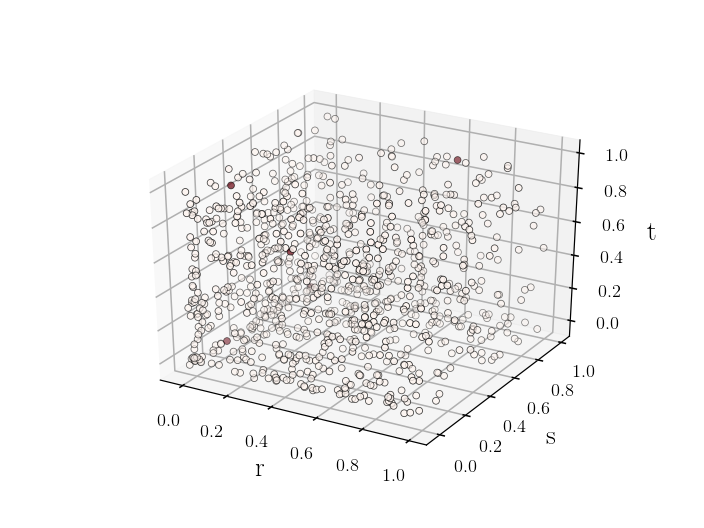

In [8]:
from mpl_toolkits.mplot3d import Axes3D

threedee = plt.figure().gca(projection='3d')
threedee.scatter(data['var_0070'], data['var_0080'], zs=data['var_0015'], 
                 c=data["labels"], edgecolor='black')
threedee.set_xlabel('r', labelpad=10)
threedee.set_ylabel('s', labelpad=10)
threedee.set_zlabel('t', labelpad=10)

plt.savefig("3d-plot-non-outlier.svg", format="svg")

# Autoencoder 

In [10]:
from scipy.io import arff
import pandas as pd

data, meta = arff.loadarff("synth_multidim_100_000.arff")
data = pd.DataFrame(data)

In [11]:
labels = data['class'].astype(int)
labels[labels != 0] = 1
del data['class']

In [12]:
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(data)
data_n = pd.DataFrame(np_scaled)
data_n = data_n.astype('float32')

In [13]:
from keras.layers import Input, Dense
from keras.models import Model

# this is the size of our encoded representations
encoding_dim = 80  # 80 floats -> compression of factor 0.8, assuming the input is 100 floats

# this is our input placeholder
input = Input(shape=(100,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(100, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(inputs=input, outputs=decoded)

Using TensorFlow backend.


In [14]:
# this model maps an input to its encoded representation
encoder = Model(inputs=input, outputs=encoded)

In [15]:
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(inputs=encoded_input, outputs=decoder_layer(encoded_input))

In [16]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [17]:
# Just compute the distance before learning (show be very bad !)
import numpy as np

encoded = encoder.predict(data_n.values)
decoded = decoder.predict(encoded)
naivedist = np.zeros(len(data_n.values))
for i, x in enumerate(data_n.values):
    naivedist[i] = np.linalg.norm(x-decoded[i])

In [18]:
data['naivedist'] = naivedist

In [19]:
autoencoder.fit(data_n.values, data_n.values,
                nb_epoch=2500,
                batch_size=100,
                shuffle=True,
                verbose=0)

/home/fouchee/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


# Evaluation

In [20]:
encoded = encoder.predict(data_n.values)
decoded = decoder.predict(encoded)

In [21]:
import numpy as np

dist = np.zeros(len(data_n.values))
for i, x in enumerate(data_n.values):
    dist[i] = np.linalg.norm(x-decoded[i]) # euclidean distance

In [22]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(labels, dist)
roc_auc = auc(fpr, tpr)

<IPython.core.display.Javascript object>


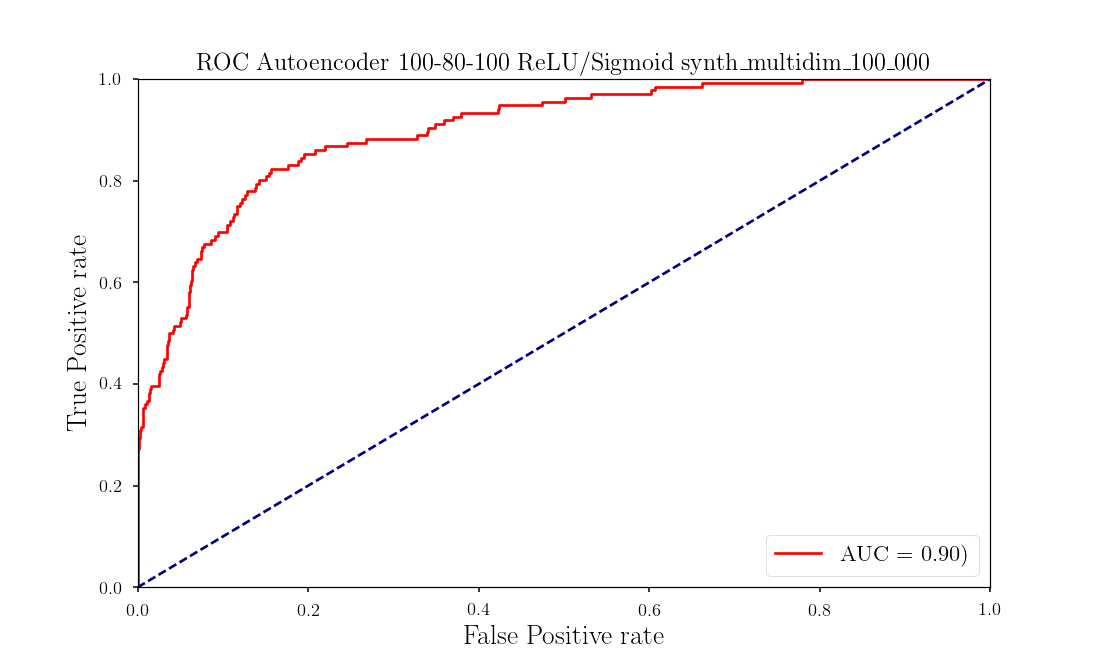

In [36]:
plt.figure(figsize=(10,6))
plt.plot(fpr, tpr, color='red', label='AUC = %0.2f)' % roc_auc)
plt.xlim((0,1))
plt.ylim((0,1))
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive rate')
plt.ylabel('True Positive rate')
plt.title('ROC Autoencoder 100-80-100 ReLU/Sigmoid synth\_multidim\_100\_000', fontsize=16)
plt.legend(loc="lower right")
plt.show()
plt.savefig("ae-outlier-training-roc.svg", format="svg")

In [39]:
data['labels'] = labels
data['dist'] = dist

<IPython.core.display.Javascript object>


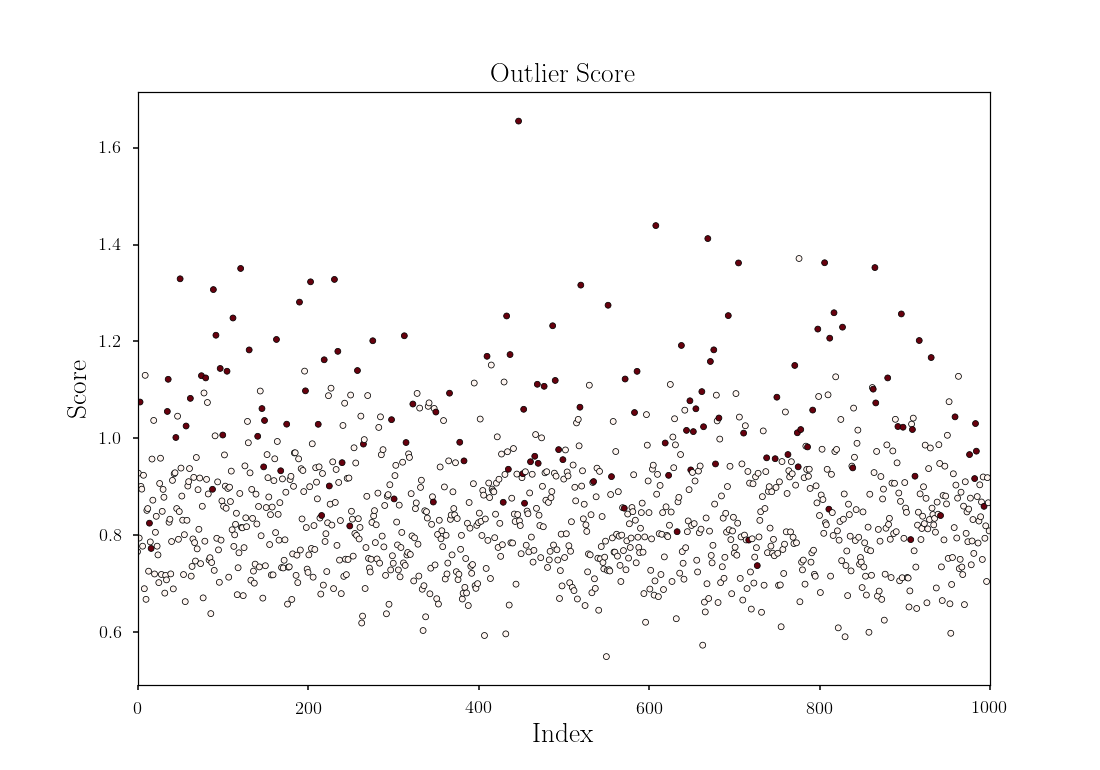

In [40]:
plt.figure(figsize=(10,7))
plt.scatter(data.index, data['dist'], c=data['labels'], edgecolor='black', s=15)
plt.xlabel('Index')
plt.ylabel('Score')
plt.xlim((0,1000))
plt.title("Outlier Score")
plt.show()
plt.savefig("ae-outlier-training.svg", format="svg")

<IPython.core.display.Javascript object>


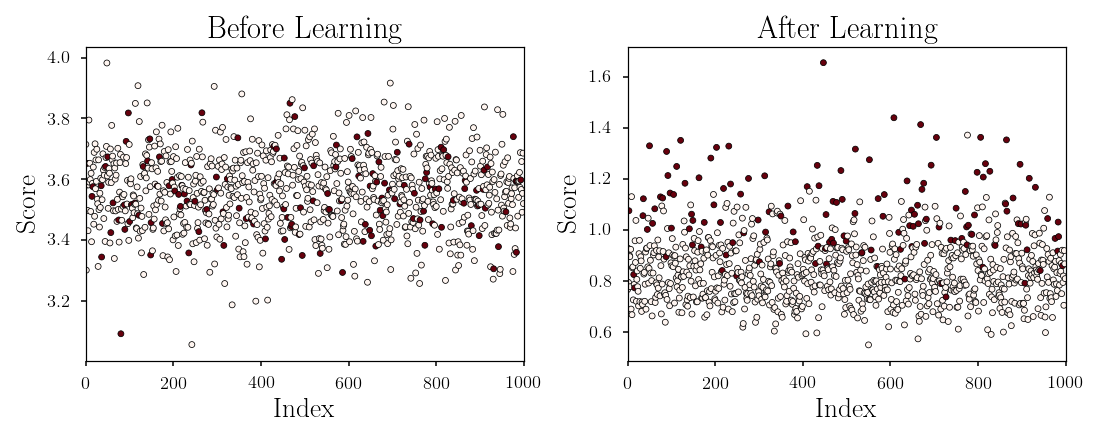

In [41]:
import matplotlib.gridspec as gridspec

# Create 1x2 sub plots
gs = gridspec.GridSpec(1, 2)

plt.figure(figsize=(10,4))
ax = plt.subplot(gs[0, 0]) # row 0, col 0
plt.scatter(data.index, data['naivedist'], c=data["labels"], edgecolor='black', s=15)
plt.xlabel("Index")
plt.ylabel('Score')
plt.xlim((0,1000))
plt.title("Before Learning", fontsize="20")

ax = plt.subplot(gs[0, 1]) # row 0, col 1
plt.scatter(data.index, data['dist'], c=data["labels"], edgecolor='black', s=15)
plt.xlabel('Index')
plt.ylabel('Score')
plt.xlim((0,1000))
plt.title("After Learning", fontsize="20")

plt.tight_layout()
plt.savefig("ae-outlier-training-comp.svg", format="svg")



<IPython.core.display.Javascript object>


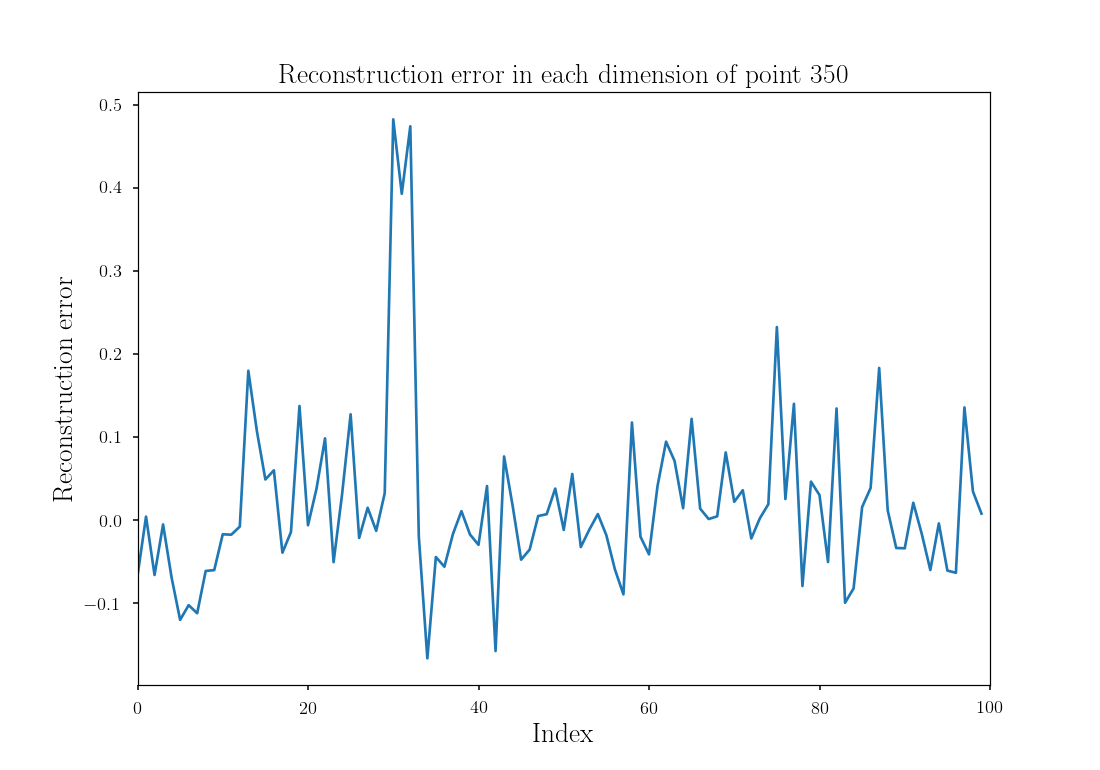

In [42]:
def compute_error_per_dim(point):
    p = np.array(data_n.iloc[point,:]).reshape(1,100)
    encoded = encoder.predict(p)
    decoded = decoder.predict(encoded)
    return np.array(p - decoded)[0]

plt.figure(figsize=(10,7))
plt.plot(compute_error_per_dim(350))
plt.xlim((0,100))
plt.xlabel('Index')
plt.ylabel('Reconstruction error')
plt.title("Reconstruction error in each dimension of point 350")
plt.savefig("ae-outlier-reconstruction-350.svg", format="svg")

<IPython.core.display.Javascript object>


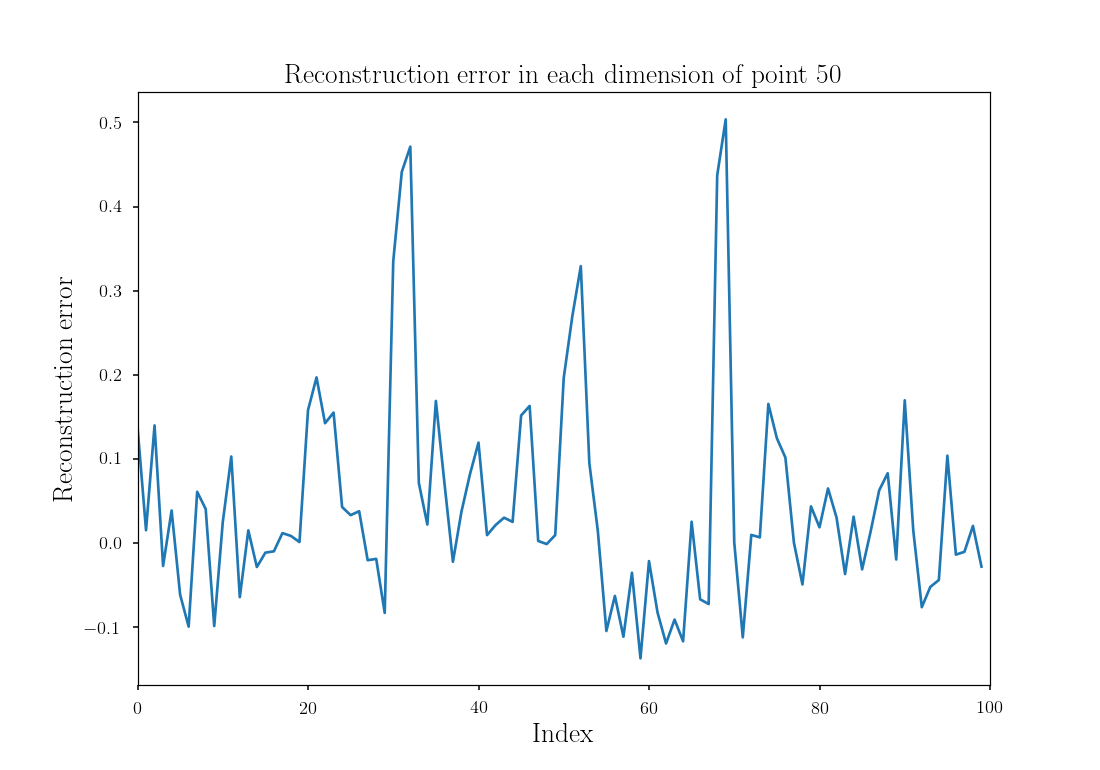

In [43]:
plt.figure(figsize=(10,7))
plt.plot(compute_error_per_dim(50))
plt.xlim((0,100))
plt.xlabel('Index')
plt.ylabel('Reconstruction error')
plt.title("Reconstruction error in each dimension of point 50")
plt.savefig("ae-outlier-reconstruction-50.svg", format="svg")

In [29]:
# Return a list of the dimensions with the highest reconstruction error
np.argsort(compute_error_per_dim(50))[::-1]

array([69, 32, 31, 68, 30, 52, 51, 21, 50, 90, 35, 74, 46, 20, 23, 45, 22,
        2,  0, 75, 40, 95, 11, 76, 53, 88, 39, 36, 33, 81, 87,  7, 79, 24,
        8,  4, 26, 38, 25, 84, 82, 43, 65, 44, 10, 34, 42, 98, 80,  1, 13,
       91, 54, 86, 17, 72, 49, 41, 18, 73, 47, 19, 70, 77, 48, 16, 97, 15,
       96, 28, 89, 27, 60, 37,  3, 99, 14, 85, 58, 83, 94, 78, 93,  5, 56,
       12, 66, 67, 92, 61, 29, 63,  9,  6, 55, 57, 71, 64, 62, 59])

<IPython.core.display.Javascript object>


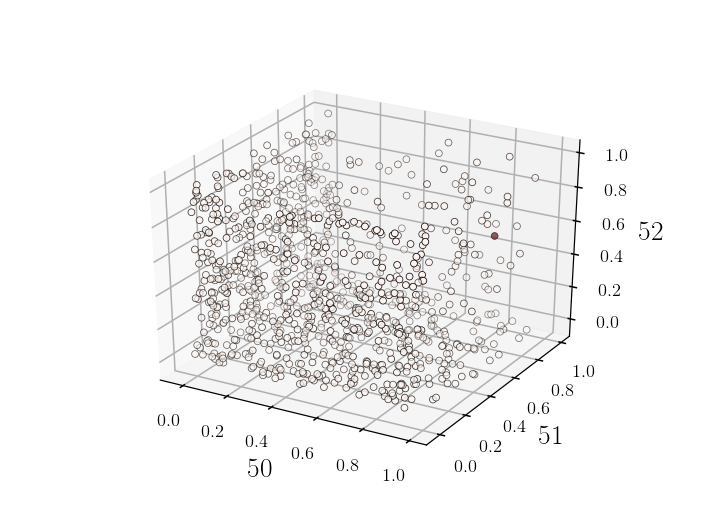

In [44]:
# Look at the position of point 50 in subspace [50,51,52]
data['labels'] = 0
data.loc[data.index.isin([50]),'labels'] = 1

from mpl_toolkits.mplot3d import Axes3D
threedee = plt.figure().gca(projection='3d')
threedee.scatter(data['var_0050'], data['var_0051'], zs=data['var_0052'], 
                 c=data["labels"], edgecolor="black")
threedee.set_xlabel('50', labelpad=10)
threedee.set_ylabel('51', labelpad=10)
threedee.set_zlabel('52', labelpad=10)
plt.savefig("3d-plot-non-outlier-50.svg", format="svg")

<IPython.core.display.Javascript object>


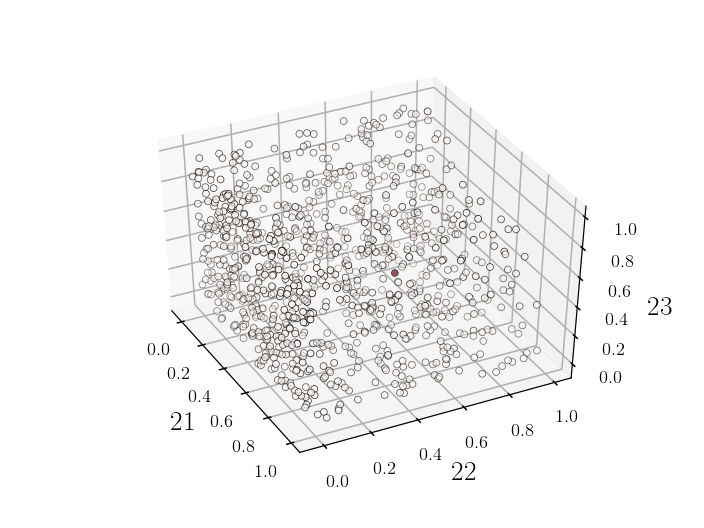

In [45]:
# Look at the position of point 50 in subspace [21,22,23]
data['labels'] = 0
data.loc[data.index.isin([50]),'labels'] = 1

from mpl_toolkits.mplot3d import Axes3D
threedee = plt.figure().gca(projection='3d')
threedee.scatter(data['var_0021'], data['var_0022'], zs=data['var_0023'], 
                 c=data["labels"], edgecolor="black")
threedee.set_xlabel('21', labelpad=10)
threedee.set_ylabel('22', labelpad=10)
threedee.set_zlabel('23', labelpad=10)

<IPython.core.display.Javascript object>


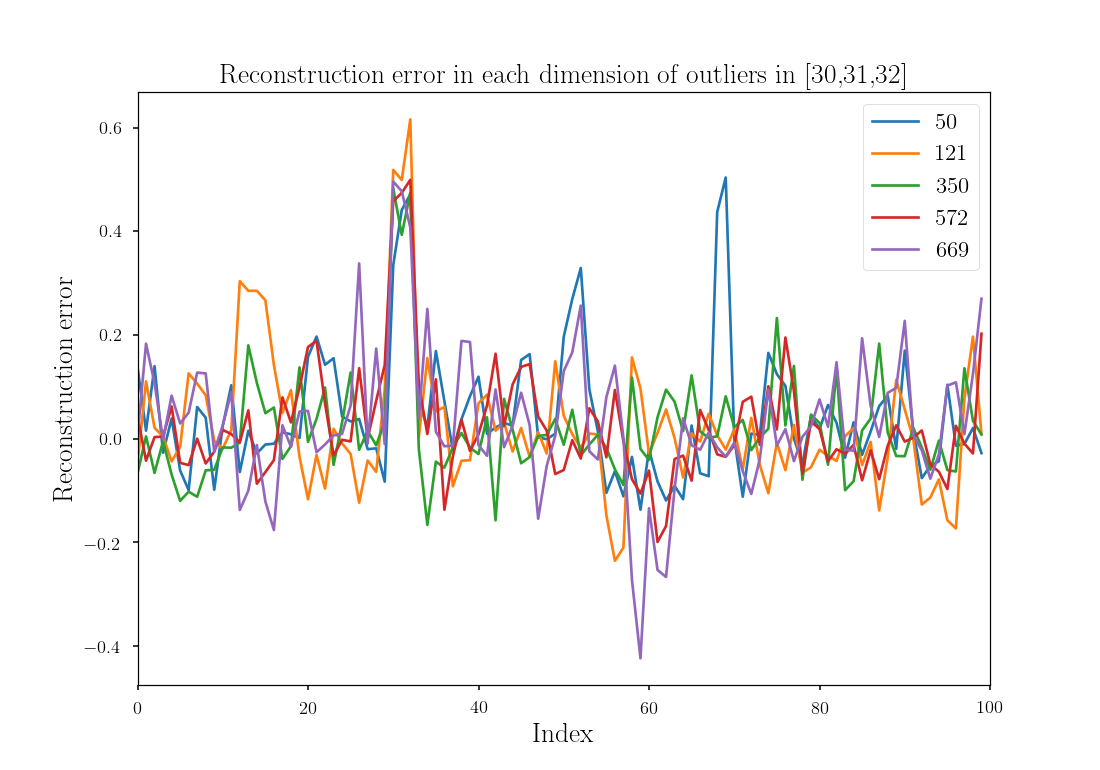

In [46]:
# 50, 121, 350, 572 and 559 are outliers in subspace [30,31,32]
plt.figure(figsize=(10,7))
plt.xlim((0,100))
plt.plot(range(100), compute_error_per_dim(50), label="50")
plt.plot(range(100), compute_error_per_dim(121), label="121")
plt.plot(range(100), compute_error_per_dim(350), label="350")
plt.plot(range(100), compute_error_per_dim(572), label="572")
plt.plot(range(100), compute_error_per_dim(669), label="669")
plt.legend(loc=1)
plt.xlabel('Index')
plt.ylabel('Reconstruction error')
plt.title("Reconstruction error in each dimension of outliers in [30,31,32]")
plt.savefig("ae-outlier-reconstruction-all.svg", format="svg")

In [33]:
import keras
keras.__version__

'2.0.4'

In [35]:
import tensorflow
tensorflow.__version__

'1.1.0'